In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
import pickle as pkl
from matplotlib.colors import ListedColormap, BoundaryNorm
from FUNCTIONS_HYCOM import name_composite, create_composite
import xarray as xr
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [2]:
# Load data
combined_regions_interpolated_with_all_MLD_with_ML_properties = pkl.load(open('combined_regions_interpolated_with_all_MLD_with_ML_properties.pkl', 'rb'))


In [3]:
# Choose MLD to use for classification between the 3 algorithms

# MLD = combined_regions_interpolated_with_all_MLD["tempMLD"]
# MLD_tag = 'tempMLD'
# MLD = combined_regions_interpolated_with_all_MLD["salinityMLD"]
# MLD_tag = 'salinityMLD'
MLD = combined_regions_interpolated_with_all_MLD_with_ML_properties["densityMLD"]
MLD_tag = 'densityMLD'

# Vertical structure of absolute salinity, to use for classification
data = combined_regions_interpolated_with_all_MLD_with_ML_properties.salinity_abs

# Inputs to decide which incr/decr mask to use
ML_delta = 50 # 1/2 1/3 2/3 1 10 20 30 40 50 60 70 
mode_tag = 'absolute' # 'fraction' # 'absolute'
mask_tag = 'plus50m' # 1ML halfML 1thirdML 2thirdML plus10m plus20m plus30m plus40m plus50m plus60m plus70m



In [73]:
# Indexes needed for composite calculation & plots 
# -2 days and +14 days
desired_day = -2
index_time_start = int((np.abs(combined_regions_interpolated_with_all_MLD_with_ML_properties.delta_time - int(desired_day * 24 * 60 * 60 * 1E9))).argmin()) # 2 days prior
desired_day = 14
index_time_end = int((np.abs(combined_regions_interpolated_with_all_MLD_with_ML_properties.delta_time - int(desired_day * 24 * 60 * 60 * 1E9))).argmin()) # 14 days after
desired_day = 0
index_time_event = int((np.abs(combined_regions_interpolated_with_all_MLD_with_ML_properties.delta_time - int(desired_day * 24 * 60 * 60 * 1E9))).argmin()) # 2 days prior


In [5]:
def HYCOM_inc_dec_BL(data, MLD_T, MLD_PD, ML_delta, mode_tag):
    # Initialize lists for masks
    mask_incr = []
    mask_decr = []
    mask_inc_BL = []
    mask_dec_BL = []
    mask_inc_noBL = []
    mask_dec_noBL = []
    mask_all_BL = []
    mask_all_noBL = []
    
    negative_MLD_count = 0

    for i_event in np.arange(data.shape[0]):  # loop across events
        # Check if MLD values are negative
        if any(ml_d < 0 for ml_d in [MLD_T[i_event][index_time_start], MLD_PD[i_event][index_time_start]]):
            # If MLD is negative, set all masks for this event to False
            mask_incr.append(0)
            mask_decr.append(0)
            mask_inc_BL.append(0)
            mask_dec_BL.append(0)
            mask_inc_noBL.append(0)
            mask_dec_noBL.append(0)
            mask_all_BL.append(0)
            mask_all_noBL.append(0)
            
            # Increment the negative MLD count
            negative_MLD_count += 1
            
        else:
            # MIXED LAYER
            # Find depth index to insert ML
            i_depth_MLD = np.searchsorted(data[i_event].depth.values, MLD[i_event][index_time_start])
            # Create new depth axis which includes MLD
            depth_MLD = np.insert(data[i_event].depth.values, i_depth_MLD, MLD[i_event][index_time_start])
            # Calculate salinity at MLD via interpolation
            salinity_abs_upper = data[i_event][index_time_start].interp(depth=depth_MLD)

            # Calculate weighted average of salinity within the ML (from surface to MLD)
            depth_MLD_upper = np.insert(depth_MLD, i_depth_MLD, MLD[i_event][index_time_start])
            depth_MLD_upper = np.insert(depth_MLD_upper, 0, 0)

            dz = (depth_MLD_upper[2:i_depth_MLD+3] - depth_MLD_upper[0:i_depth_MLD+1]) / 2
            MLS_abs_wgt = (np.sum(dz * salinity_abs_upper[0:i_depth_MLD+1])) / np.sum(dz)

            # LAYER BELOW ML
            if mode_tag == 'fraction':
                bottom_limit = MLD[i_event][index_time_start] + MLD[i_event][index_time_start] * ML_delta
            elif mode_tag == 'absolute':
                bottom_limit = MLD[i_event][index_time_start] + ML_delta
            depth_below_ML = np.insert(depth_MLD, i_depth_MLD, MLD[i_event][index_time_start])
            i_depth_meters_below_MLD = np.searchsorted(depth_below_ML, bottom_limit)
            depth_below_ML = np.insert(depth_below_ML, i_depth_meters_below_MLD, bottom_limit)
            depth_below_ML = np.insert(depth_below_ML, i_depth_meters_below_MLD, bottom_limit)
            salinity_abs_lower = data[i_event][index_time_start].interp(depth=depth_below_ML)

            dz = (depth_below_ML[i_depth_MLD+2:i_depth_meters_below_MLD+2] - depth_below_ML[i_depth_MLD:i_depth_meters_below_MLD])/2
            salinity_abs_wgt_lower = (np.sum(dz * salinity_abs_lower[i_depth_MLD+1:i_depth_meters_below_MLD+1])) / np.sum(dz)

            mean_salinity_diff_below = salinity_abs_wgt_lower - MLS_abs_wgt

            # Calculate the difference between temperature-based MLD and density-based MLD
            MLD_diff = MLD_T[i_event][index_time_start] - MLD_PD[i_event][index_time_start]

            # Check if the difference is greater than 5 (like the distance between eachlayer)
            BL_yes_or_no = MLD_diff > 5

            # Append the result to the appropriate mask lists            
            if BL_yes_or_no:
                mask_all_BL.append(1)
                mask_all_noBL.append(0)
                mask_dec_noBL.append(0)
                mask_inc_noBL.append(0)
                if mean_salinity_diff_below > 0:
                    mask_incr.append(1)
                    mask_inc_BL.append(1)
                    mask_decr.append(0)
                    mask_dec_BL.append(0)
                elif mean_salinity_diff_below < 0:
                    mask_incr.append(0)
                    mask_inc_BL.append(0)
                    mask_decr.append(1)
                    mask_dec_BL.append(1)
                else:
                    mask_incr.append(0)
                    mask_decr.append(0)
                    mask_dec_BL.append(0)
                    mask_inc_BL.append(0)
            else:
                mask_all_noBL.append(1)
                mask_all_BL.append(0)
                mask_dec_BL.append(0)
                mask_inc_BL.append(0)
                if mean_salinity_diff_below > 0:
                    mask_incr.append(1)
                    mask_inc_noBL.append(1)
                    mask_decr.append(0)
                    mask_dec_noBL.append(0)
                elif mean_salinity_diff_below < 0:
                    mask_incr.append(0)
                    mask_inc_noBL.append(0)
                    mask_decr.append(1)
                    mask_dec_noBL.append(1)
                else:
                    mask_incr.append(0)
                    mask_decr.append(0)
                    mask_dec_noBL.append(0)
                    mask_inc_noBL.append(0)

    # Combine the masks
    combined_mask = {
        "incr": mask_incr,
        "decr": mask_decr,
        "inc_BL": mask_inc_BL,
        "dec_BL": mask_dec_BL,
        "inc_noBL": mask_inc_noBL,
        "dec_noBL": mask_dec_noBL,
        "all_BL": mask_all_BL,
        "all_noBL": mask_all_noBL
    }
    
    # Print the count of cases with negative MLD
    print(f"Number of cases with negative MLD @ -2 days: {negative_MLD_count}")
    return combined_mask


In [6]:
# Calculate increasing and decreasing masks

MLD_T = combined_regions_interpolated_with_all_MLD_with_ML_properties["tempMLD"]
MLD_PD = combined_regions_interpolated_with_all_MLD_with_ML_properties["densityMLD"]

combined_mask = HYCOM_inc_dec_BL(data, MLD_T, MLD_PD, ML_delta, mode_tag)
# combined_mask.keys()

mask_incr, mask_decr, mask_inc_BL, mask_dec_BL, mask_inc_noBL, mask_dec_noBL, mask_all_BL, mask_all_noBL = (np.ravel(combined_mask[key]).astype(bool) for key in combined_mask.keys())

# # Create a Dataset to hold all the masks
# mask_dataset = xr.Dataset({
#     "incr": xr.DataArray(mask_incr, dims='event'),
#     "decr": xr.DataArray(mask_decr, dims='event'),
#     "inc_BL": xr.DataArray(mask_inc_BL, dims='event'),
#     "dec_BL": xr.DataArray(mask_dec_BL, dims='event'),
#     "inc_noBL": xr.DataArray(mask_inc_noBL, dims='event'),
#     "dec_noBL": xr.DataArray(mask_dec_noBL, dims='event'),
#     "all_BL": xr.DataArray(mask_all_BL, dims='event'),
#     "all_noBL": xr.DataArray(mask_all_noBL, dims='event'),
# })

# # Save the Dataset to a NetCDF file
# mask_dataset.to_netcdf(f'allmasks_HYCOM_{MLD_tag}.nc')

Number of cases with negative MLD @ -2 days: 11


In [7]:
# Lat and lon data
longitudes_2d_map  = combined_regions_interpolated_with_all_MLD_with_ML_properties.longitude.values
latitudes_2d_map  = combined_regions_interpolated_with_all_MLD_with_ML_properties.latitude.values

In [8]:
# Define time intervals for histogram plots
days_plot_start = [0, 3, 6, 9, 12]
days_plot_end = [3, 6, 9, 12, 14]

# Initialize arrays to store indices
index_days_plot_start = np.zeros(len(days_plot_start), dtype=int)
index_days_plot_end = np.zeros(len(days_plot_end), dtype=int)

for i in range(len(days_plot_start)):
    desired_day = days_plot_start[i]
    index_days_plot_start[i] = int((np.abs(combined_regions_interpolated_with_all_MLD_with_ML_properties.delta_time - int(desired_day * 24 * 60 * 60 * 1E9))).argmin())

for i in range(len(days_plot_end)):
    desired_day = days_plot_end[i]
    index_days_plot_end[i] = int((np.abs(combined_regions_interpolated_with_all_MLD_with_ML_properties.delta_time - int(desired_day * 24 * 60 * 60 * 1E9))).argmin())


In [9]:
# Things to plot in histograms
mask_list = ['mask_incr', 'mask_decr']
var_list = ['temperature_anom_minus2', 'salinity_anom_minus2', 'density_anom_minus2']

In [10]:
diff_var_names = []
diff_wspd_names = []
# Iterate over intervals
for i in range(len(days_plot_start)):
    iday_start = days_plot_start[i]
    iday_end = days_plot_end[i]
    start_index = index_days_plot_start[i]
    end_index = index_days_plot_end[i]
    for ivar in var_list:
        for mask in mask_list:
            # Extract data for the current time interval
            interval_data = combined_regions_interpolated_with_all_MLD_with_ML_properties[ivar][:, start_index:end_index+1].values

            # Extract corresponding wind speed data
            interval_wspd = combined_regions_interpolated_with_all_MLD_with_ML_properties['wndspd'][:, start_index:end_index+1].values
            
            # Mask data
            interval_data_masked = interval_data[eval(mask)]
            interval_wspd_masked = interval_wspd[eval(mask)]
            
            # Calculate the nanmean for the current time interval
            interval_mean = np.nanmean(interval_data_masked, axis=1)
            interval_wspd_mean = np.nanmean(interval_wspd_masked, axis=1)

            # Create a dynamic variable name
            diff_variable_name = f"{ivar}_{mask}_{iday_start}_{iday_end}_days"
            diff_wspd_name = f"wspd_{ivar}_{mask}_{iday_start}_{iday_end}_days"

            # Assign the difference to the dynamic variable
            locals()[diff_variable_name] = interval_mean
            locals()[diff_wspd_name] = interval_wspd_mean

            # Append the variable name to the differences list
            diff_var_names.append(diff_variable_name)
            diff_wspd_names.append(diff_wspd_name)
            

<ipython-input-10-ed6a09b79de6>:22: RuntimeWarning: Mean of empty slice
  interval_mean = np.nanmean(interval_data_masked, axis=1)
<ipython-input-10-ed6a09b79de6>:23: RuntimeWarning: Mean of empty slice
  interval_wspd_mean = np.nanmean(interval_wspd_masked, axis=1)


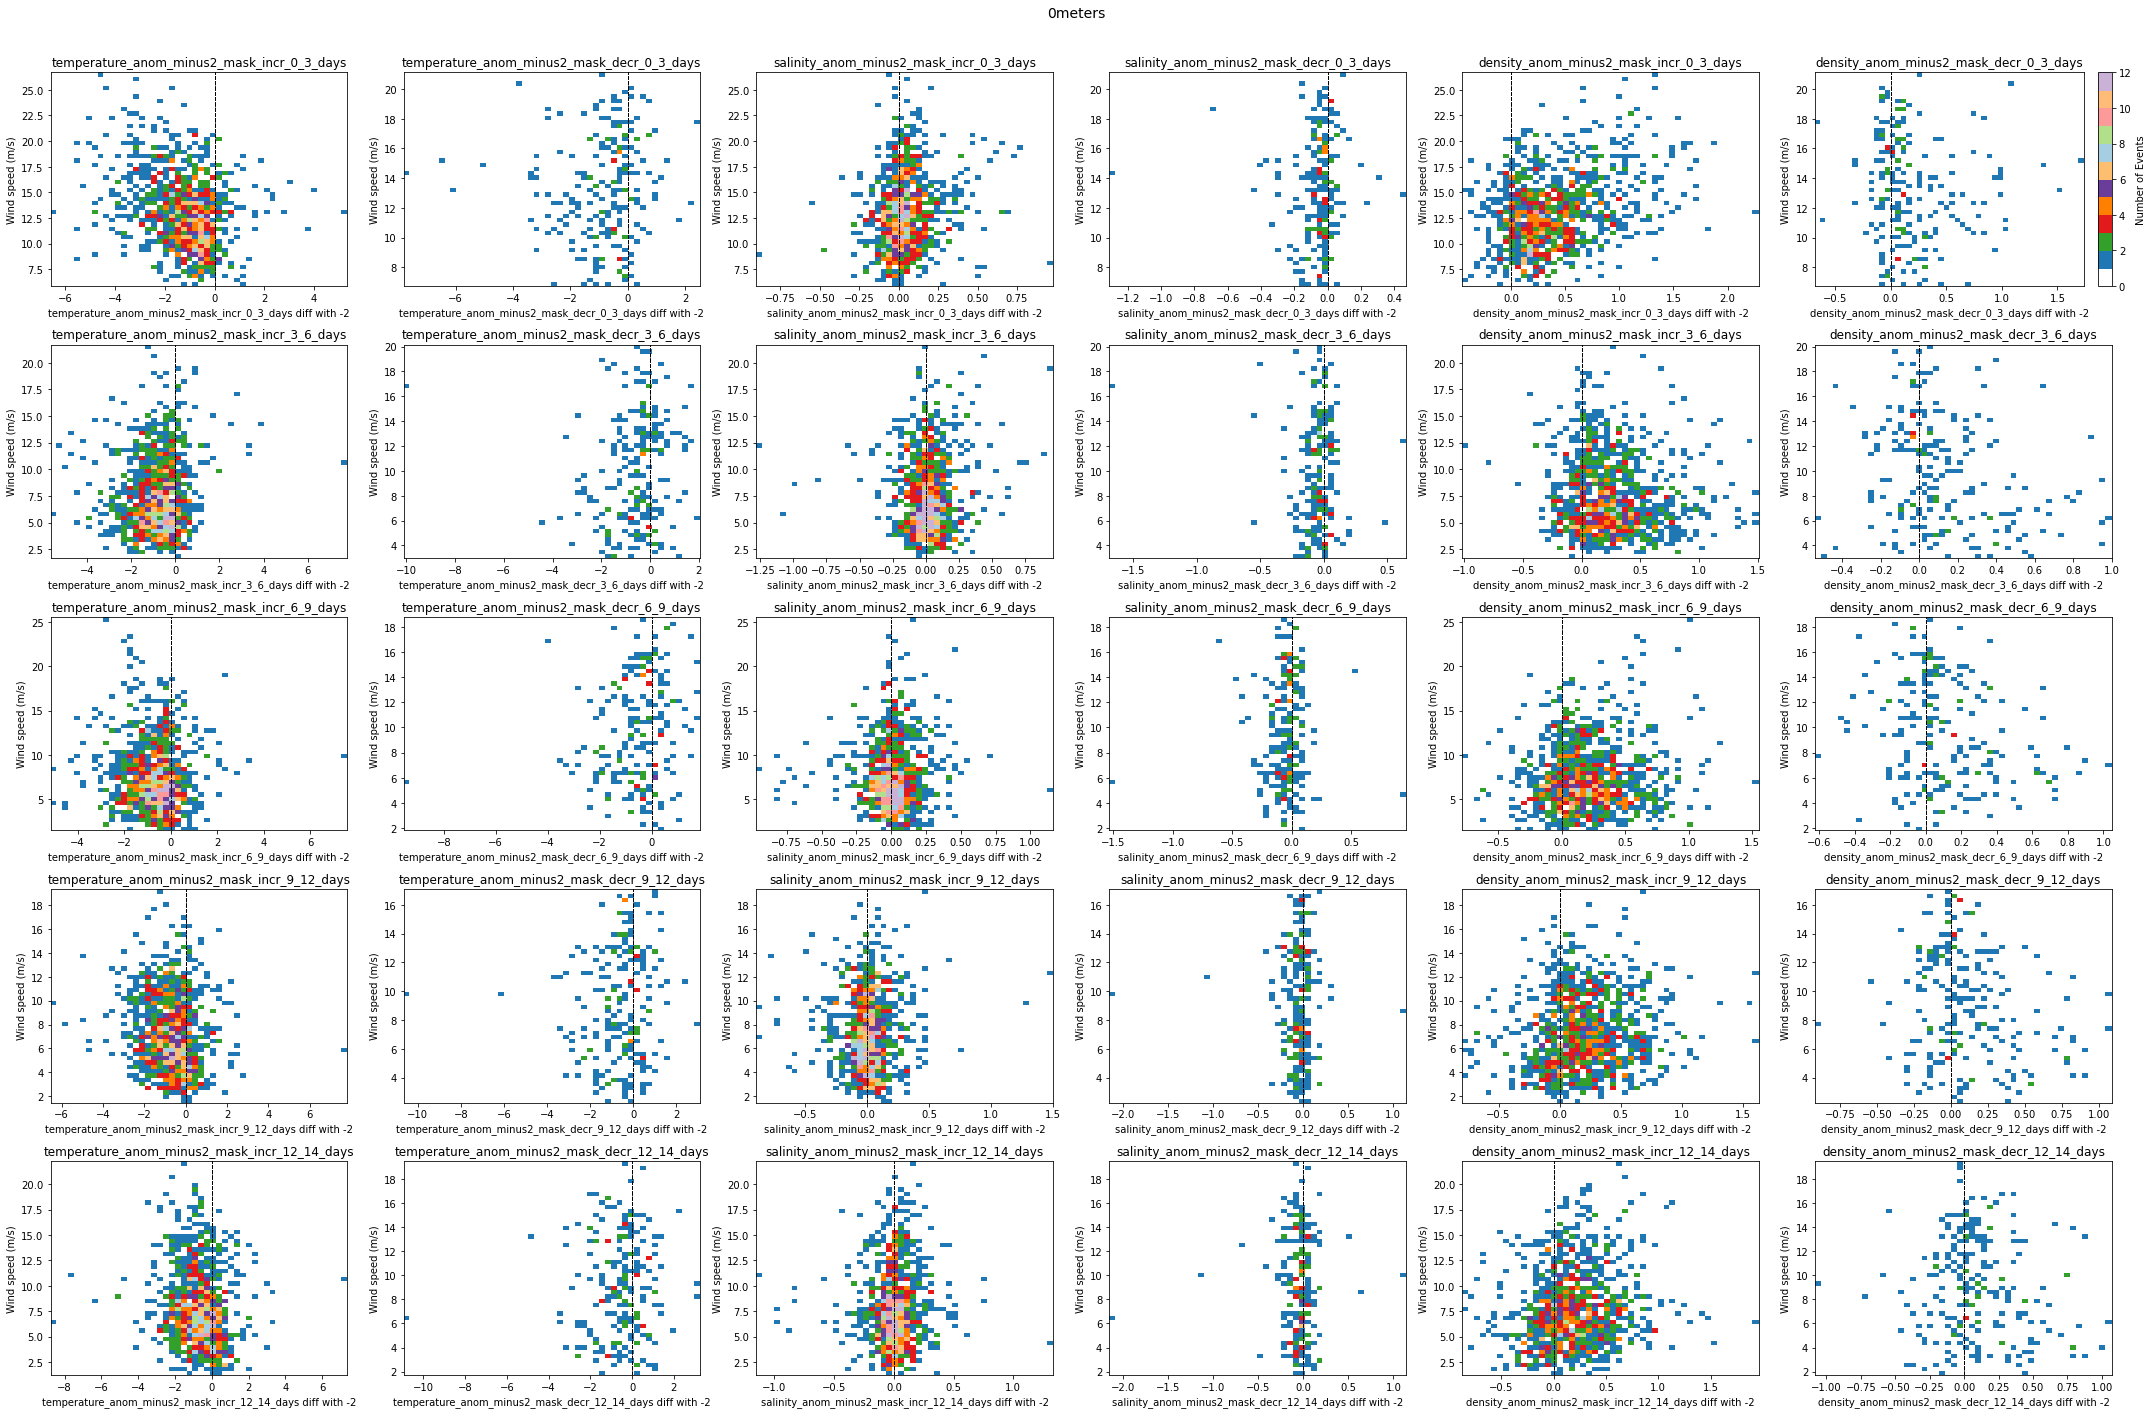

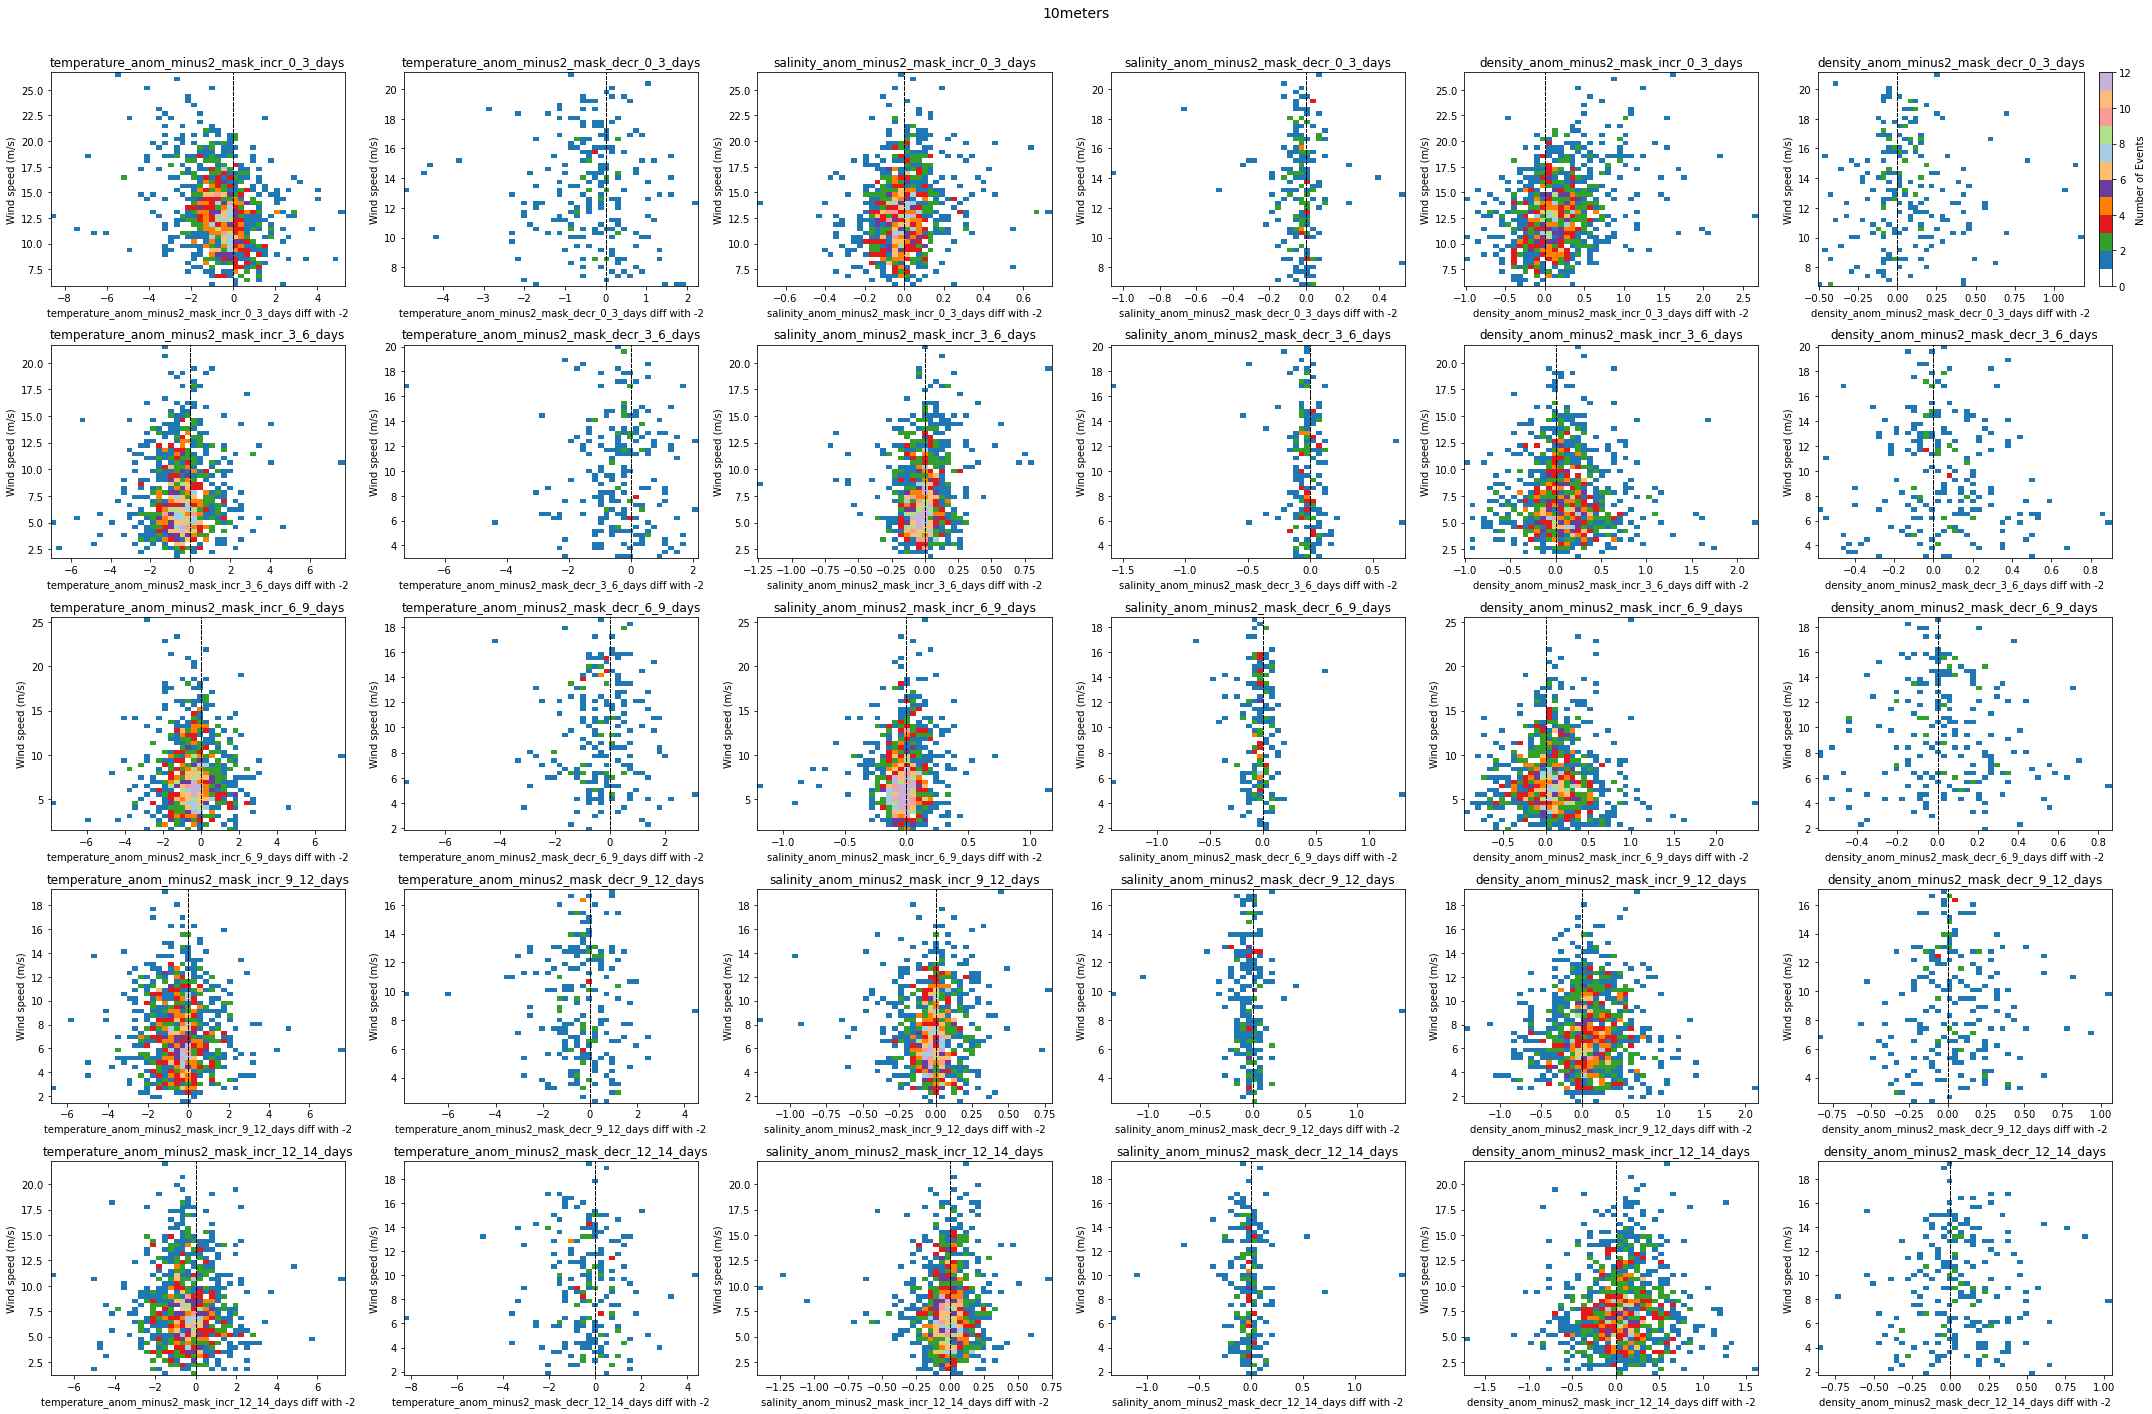

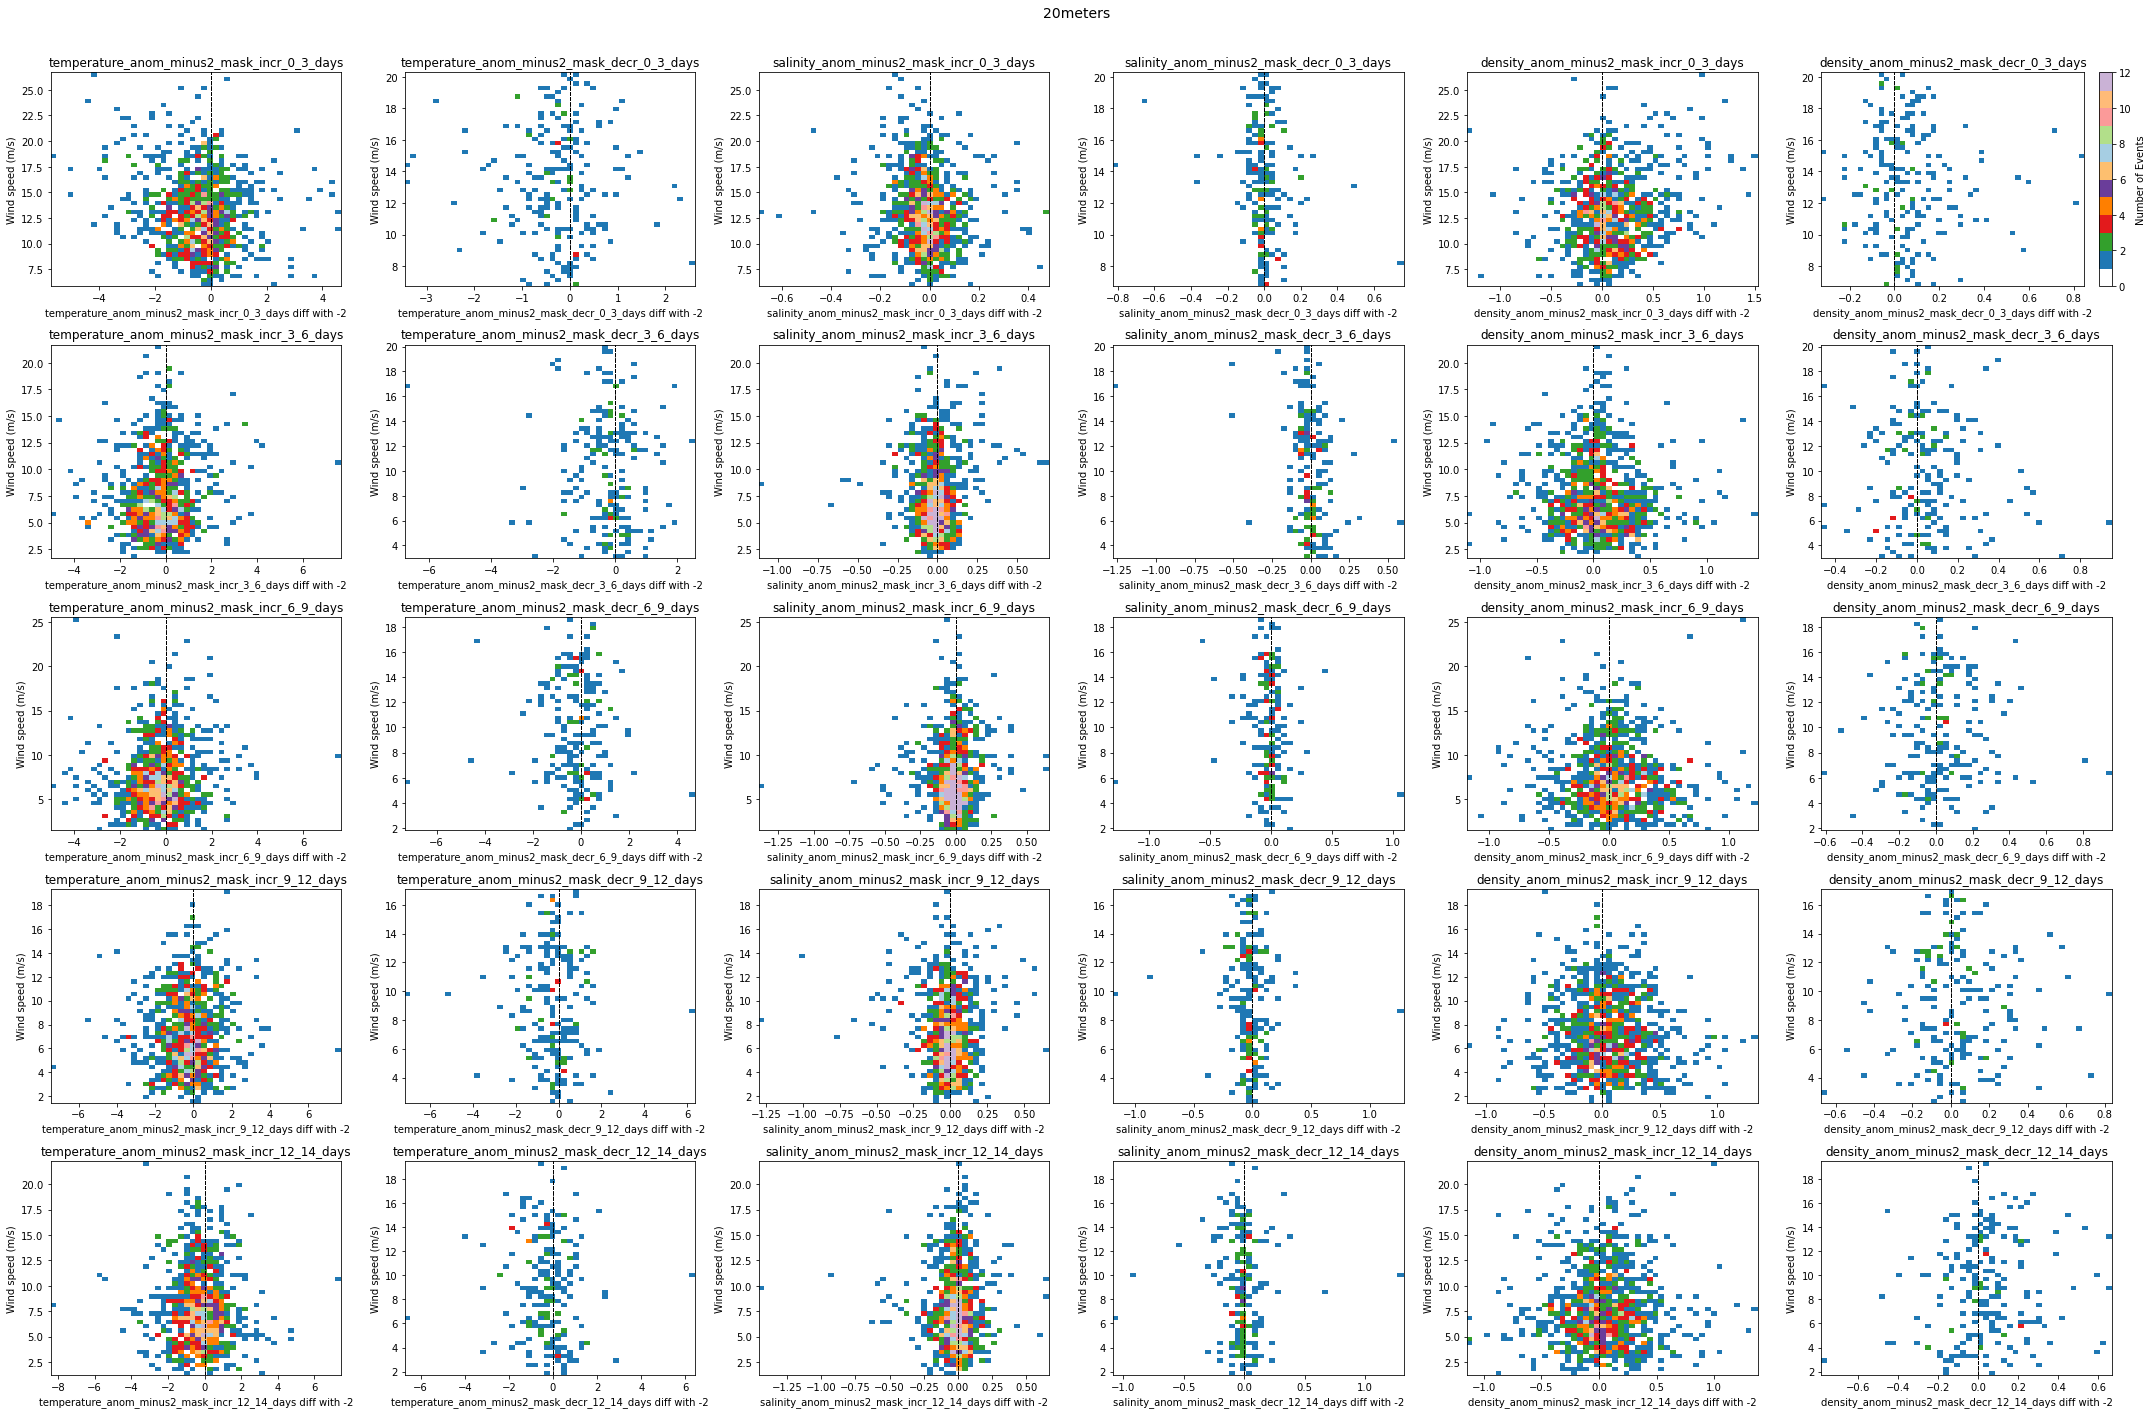

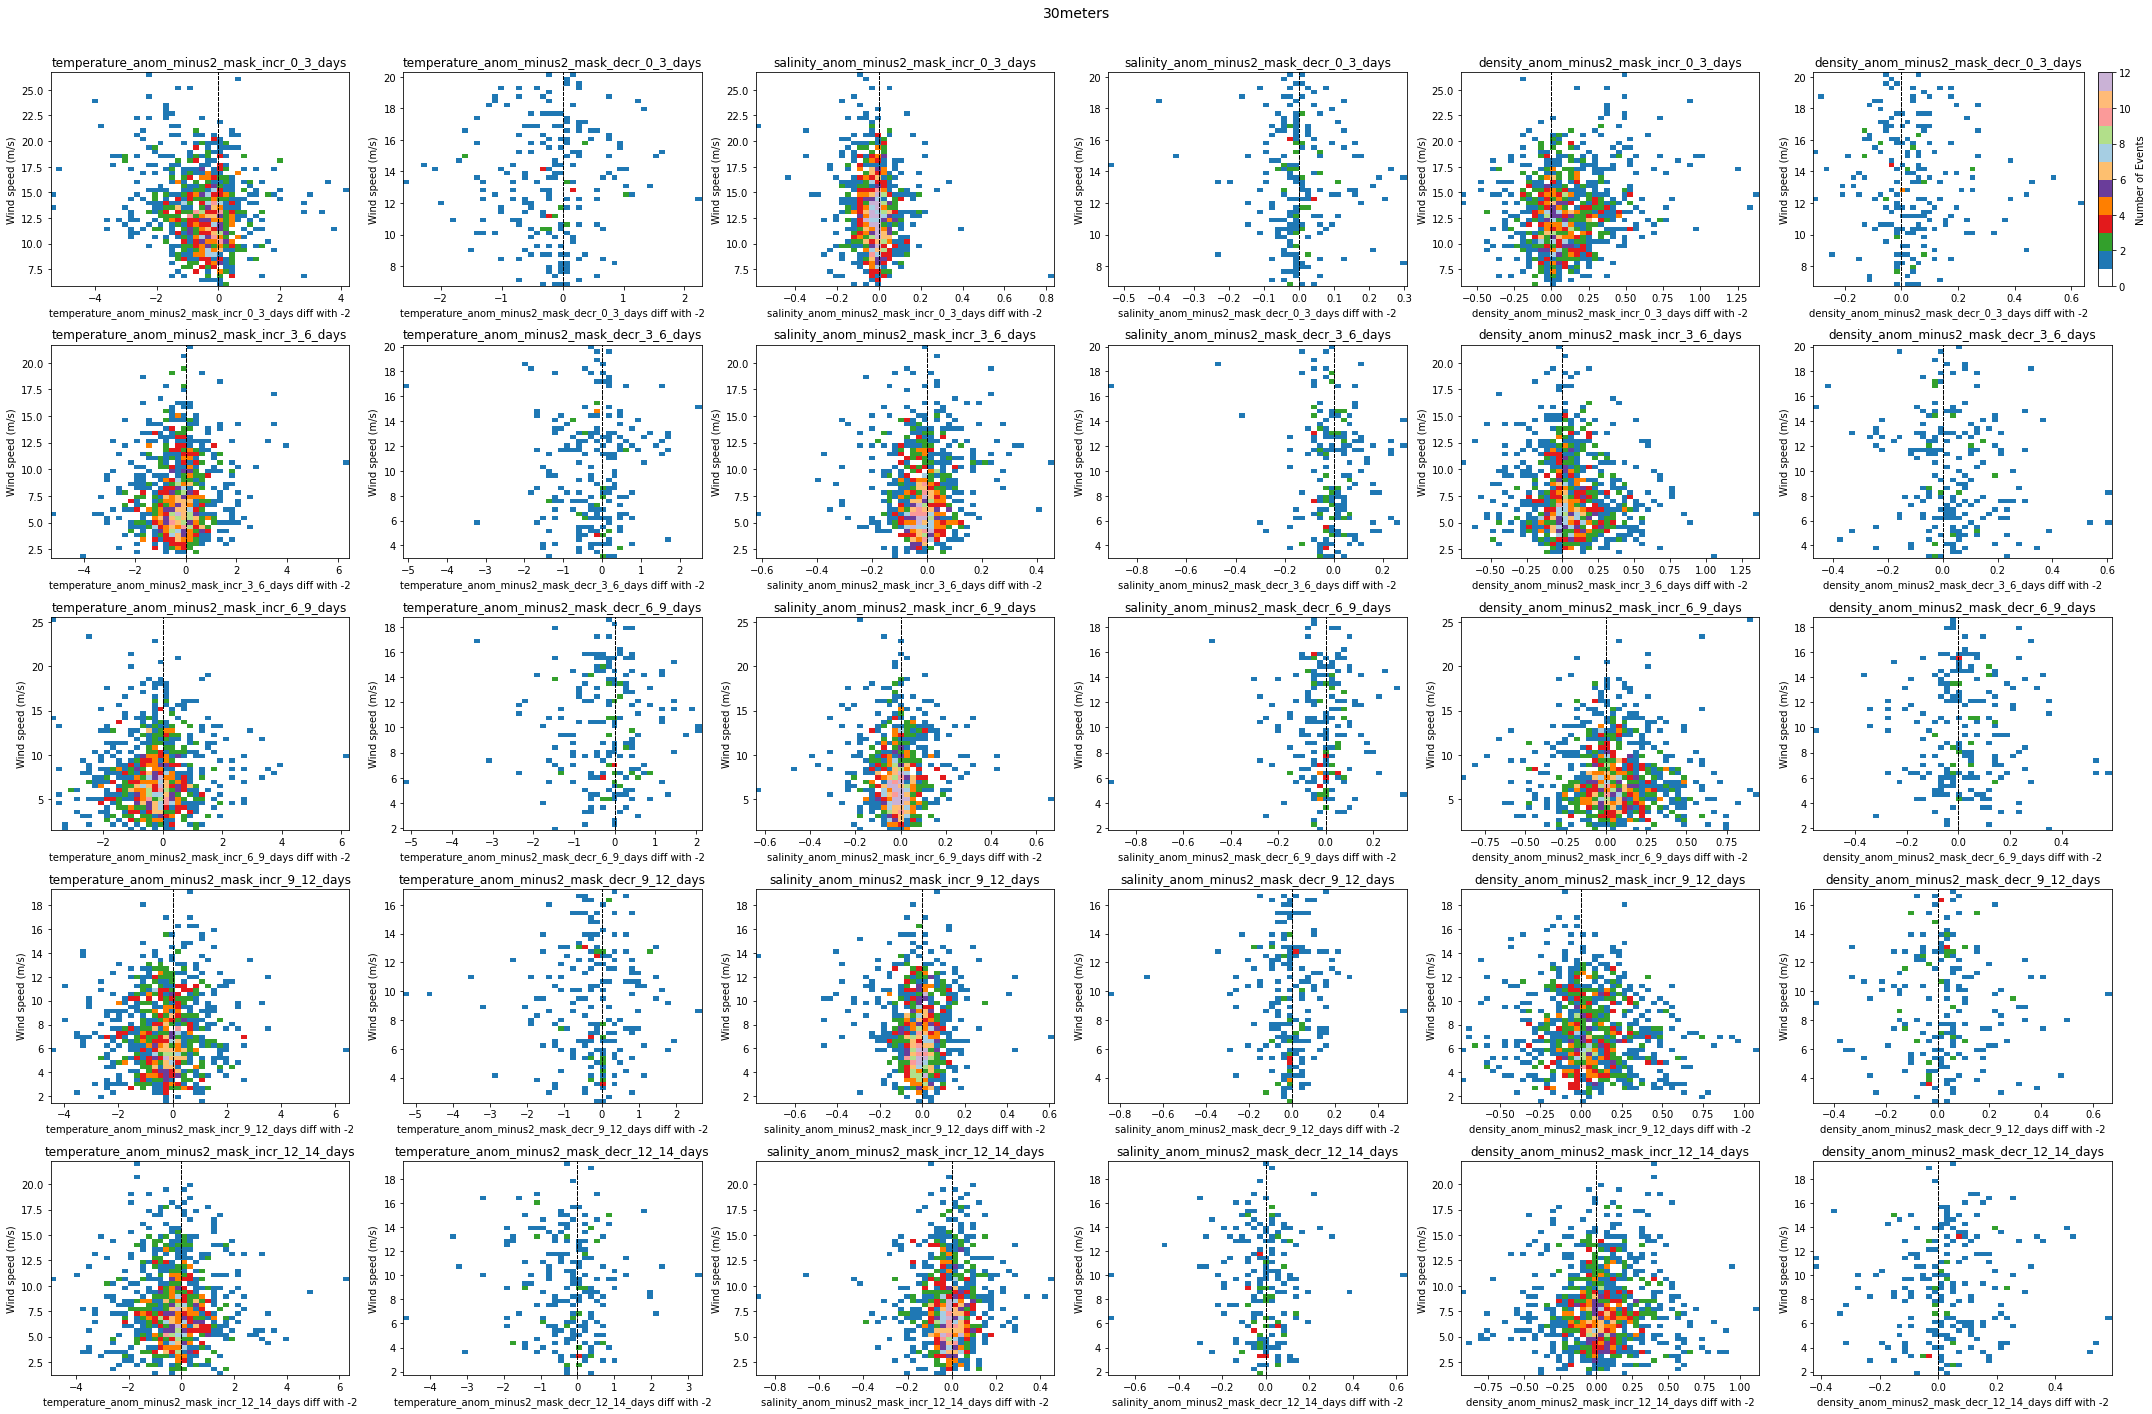

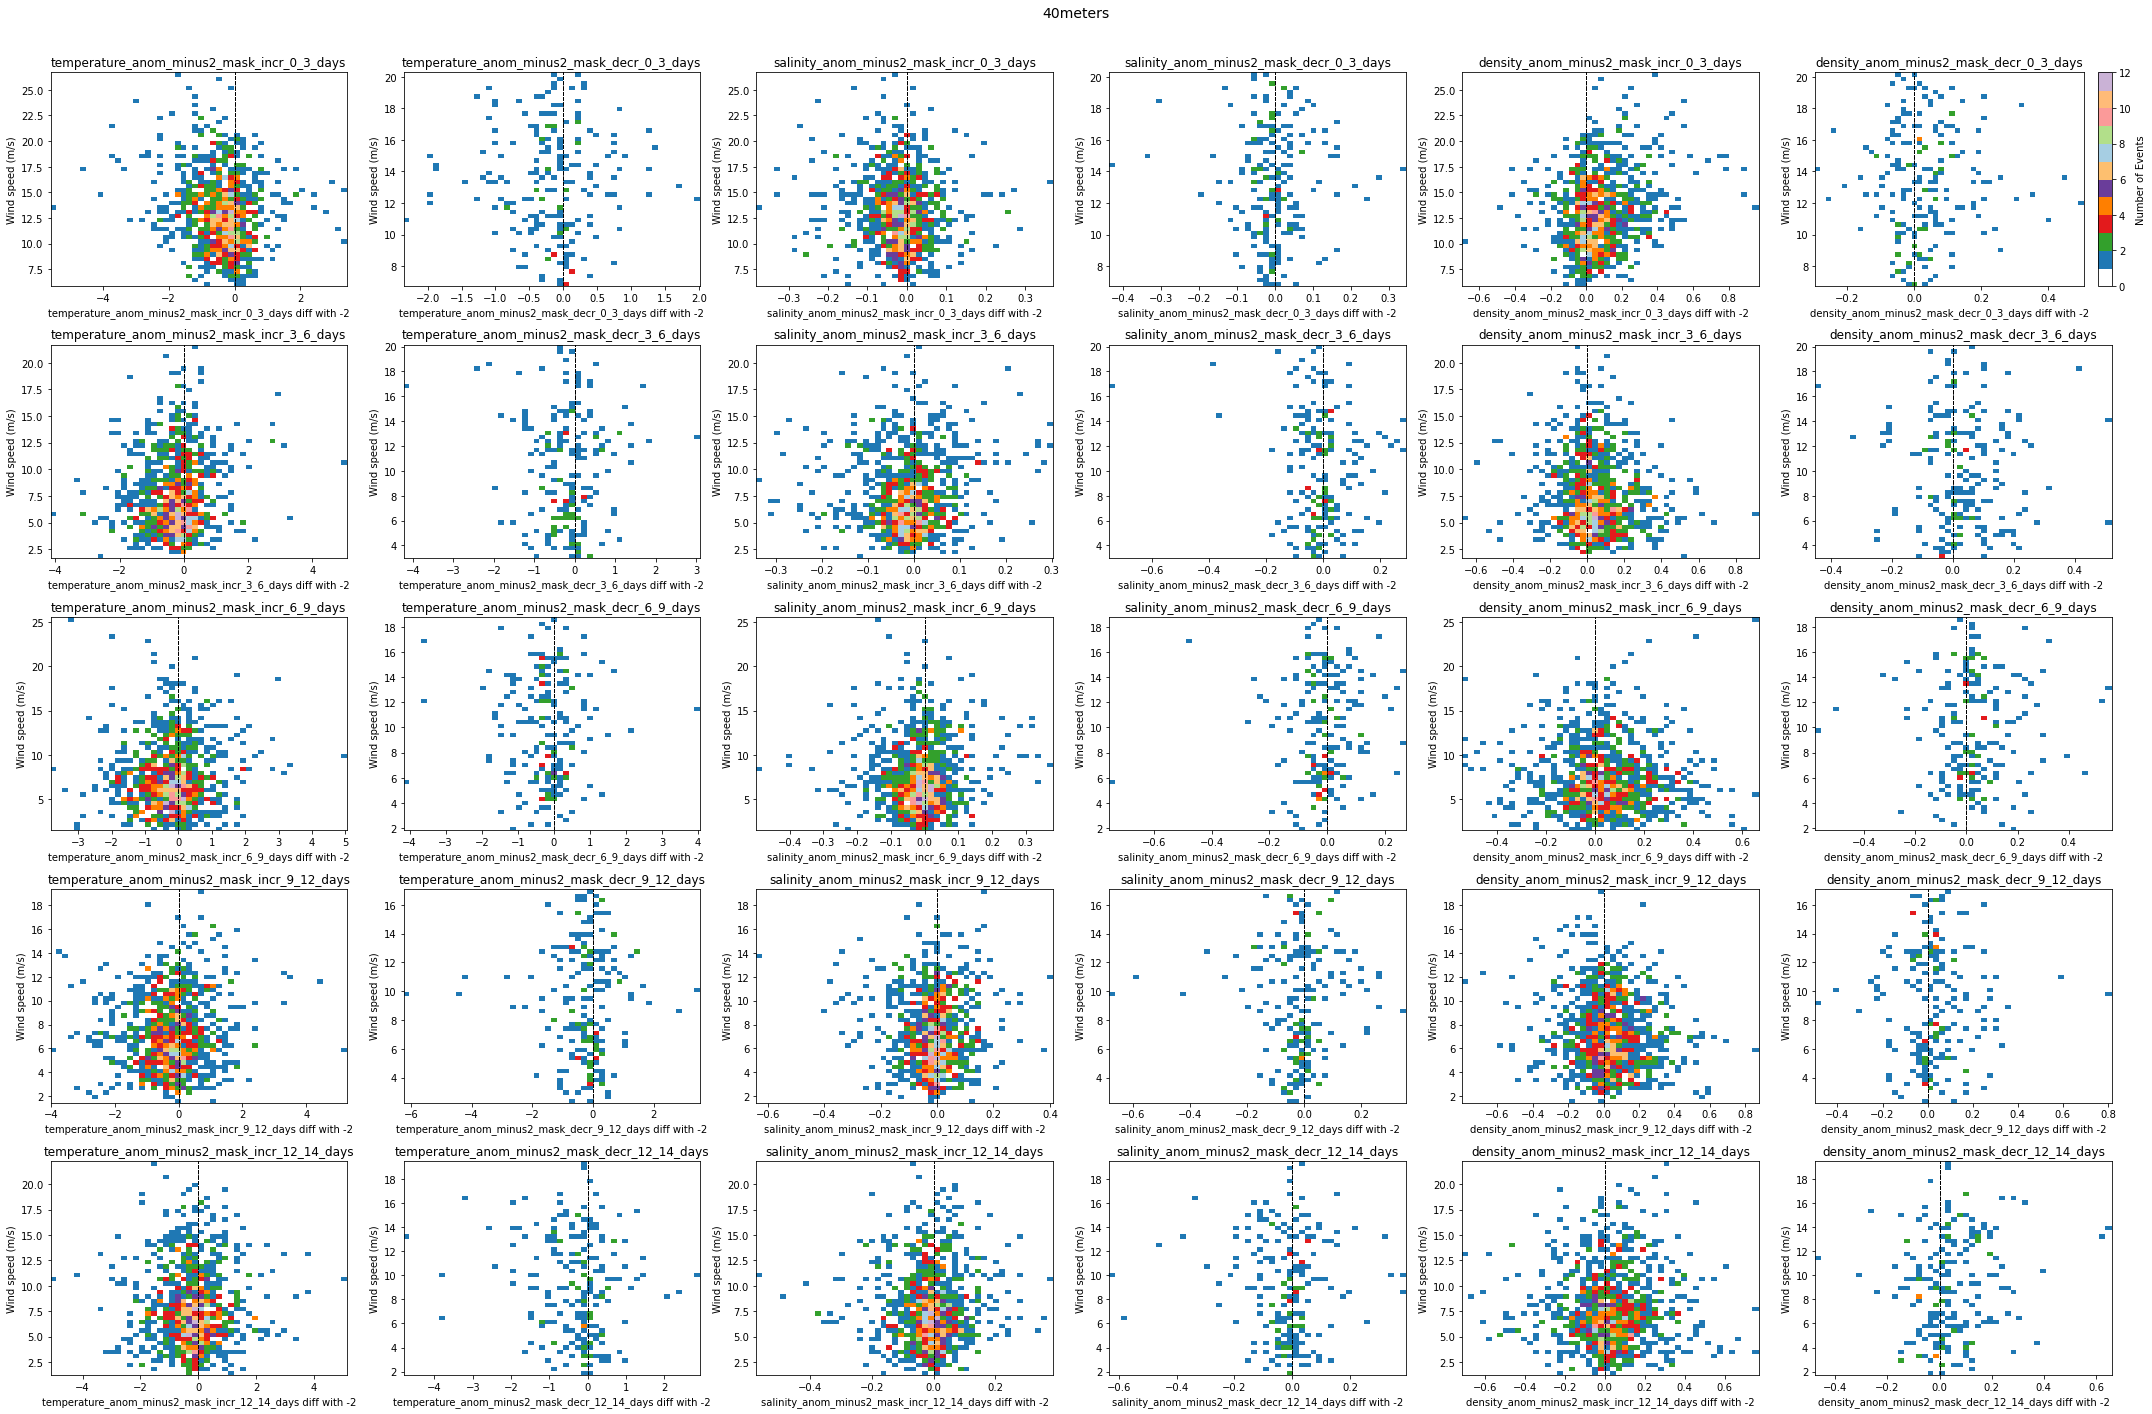

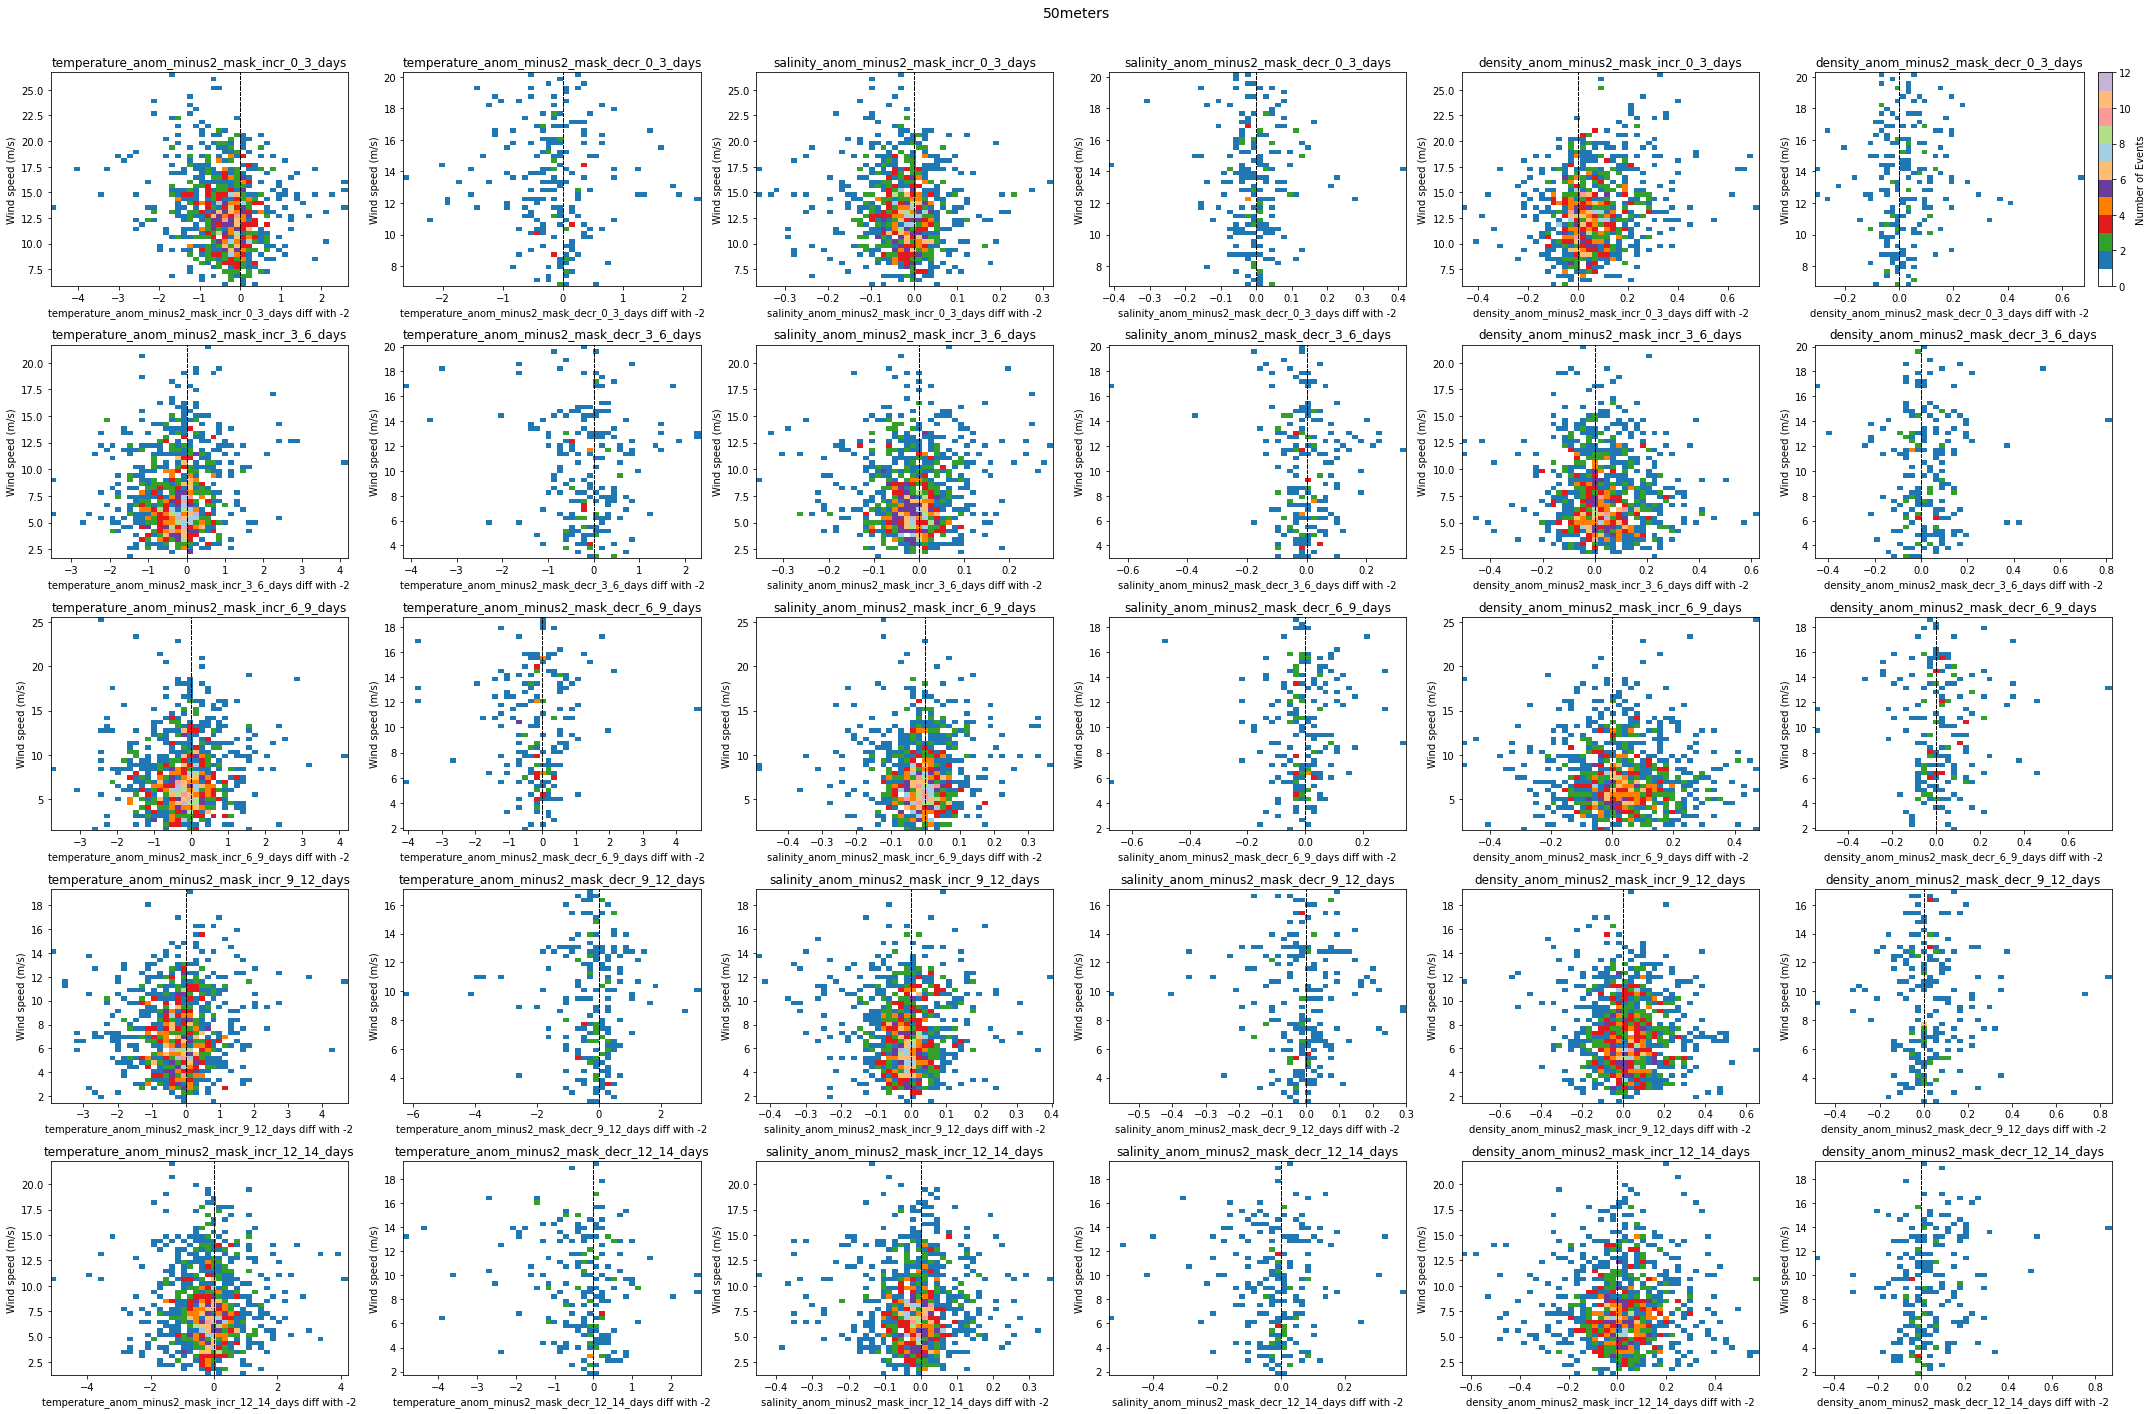

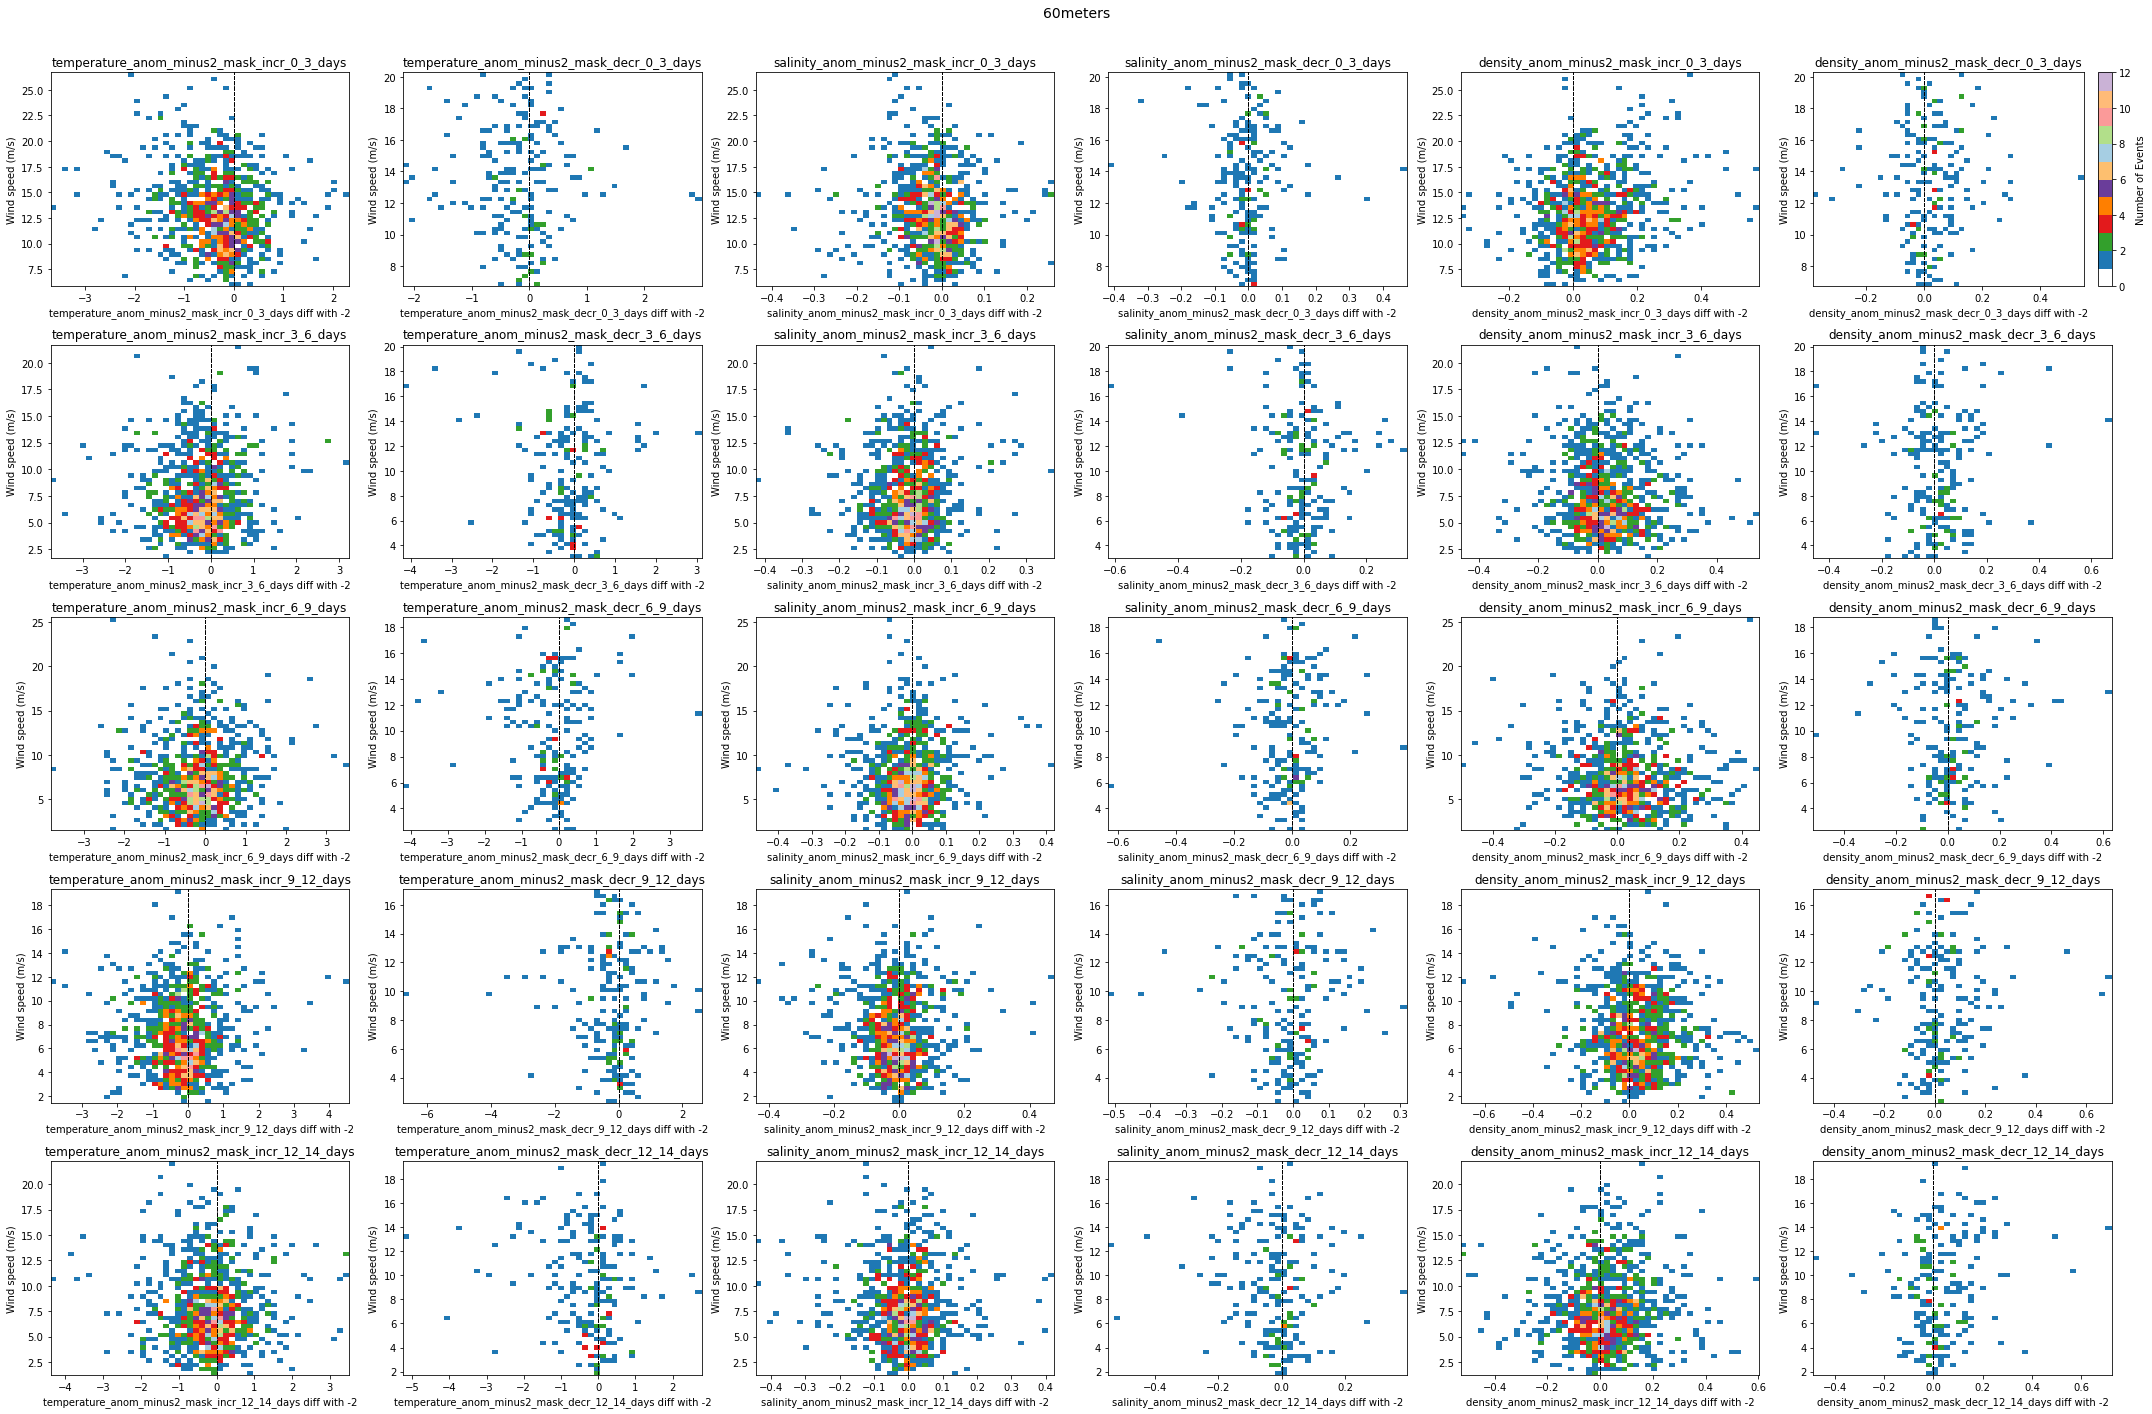

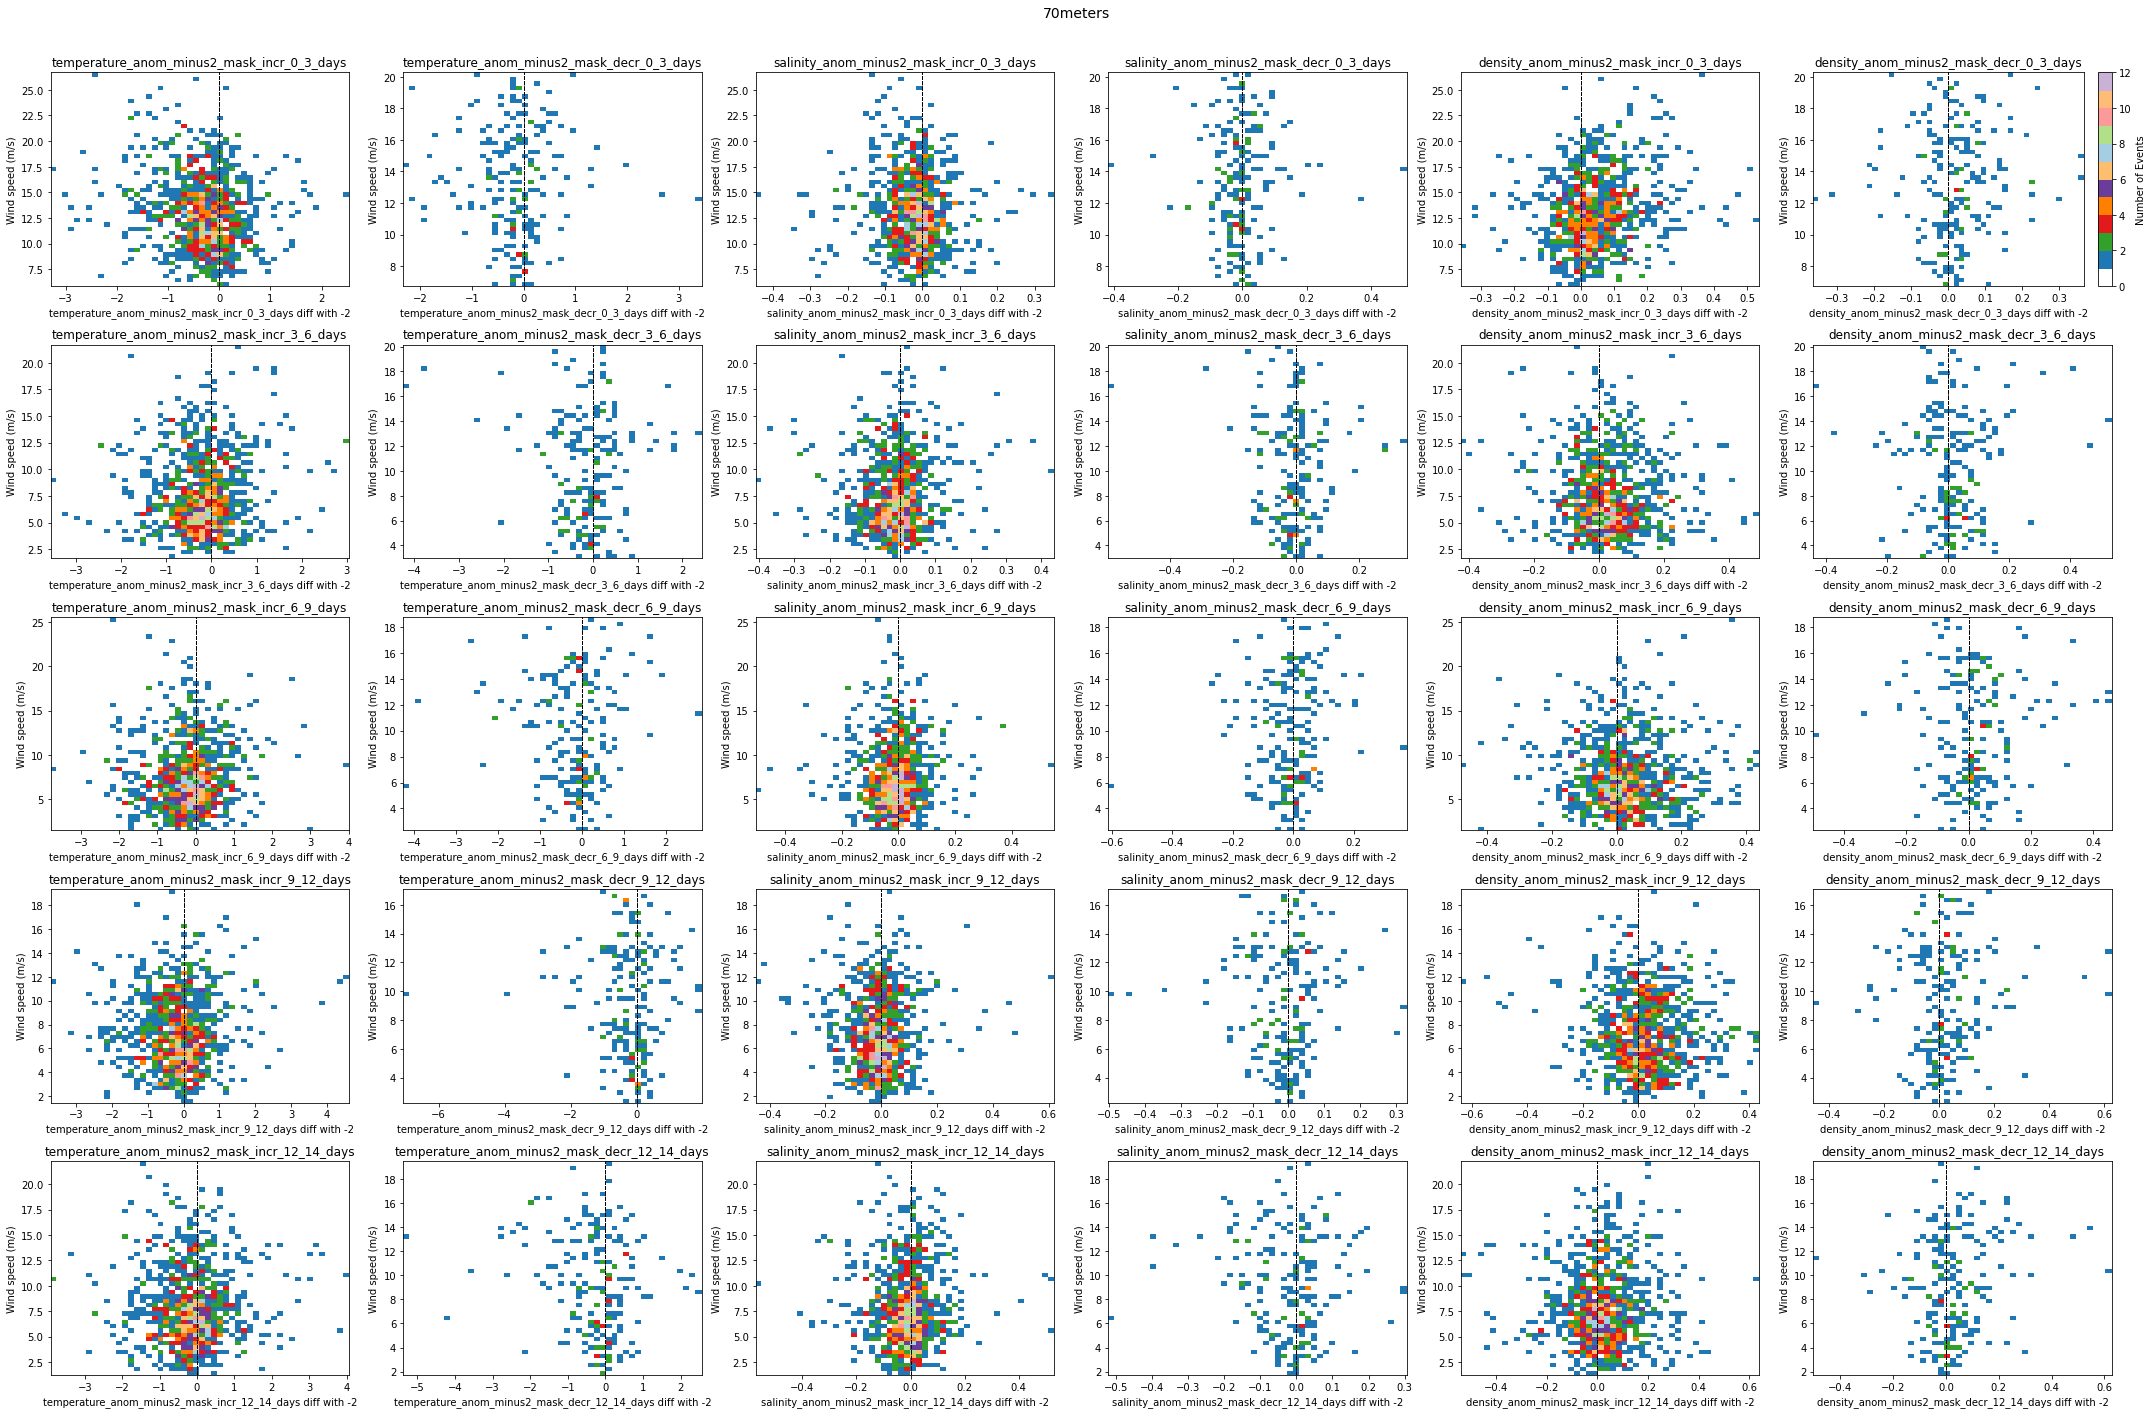

In [20]:
depth_levels = [0, 10, 20, 30, 40, 50, 60, 70]

# Define day ranges
day_ranges = [(0, 3), (3, 6), (6, 9), (9, 12), (12, 14)]

# Calculate the number of rows and columns for subplots
num_rows = 5#len(diff_var_names) // 3 + (len(diff_var_names) % 3 > 0)
num_cols = 6#min(len(diff_var_names), 3)

# Loop through depths (one plot for each depth level)
for ilev in depth_levels:
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(30, 20))  # Adjust figsize as needed
    fig.suptitle(str(ilev) + 'meters', fontsize=14)
    # Loop through day ranges
    for day_range in day_ranges:
        # Loop through variables
        for i, (variable, wind_variable) in enumerate(zip(diff_var_names, diff_wspd_names)):
            # Extract data for the first pressure level
            x = np.squeeze(eval(variable)[:, ilev])
            y = np.squeeze(eval(wind_variable)[:])

            # Handle NaN values by removing them
            valid_indices = ~np.isnan(x) & ~np.isnan(y)
            x_valid = x[valid_indices]
            y_valid = y[valid_indices]

            # Define your custom colors (12 distinct colors)
            custom_colors = ['#FFFFFF', '#1f78b4', '#33a02c', '#e31a1c', '#ff7f00', '#6a3d9a', '#fdbf6f', '#a6cee3', '#b2df8a', '#fb9a99', '#ffbb78', '#cab2d6']

            # Specify boundaries for each color in the colormap
            boundaries = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
            # Create a discrete colormap with custom colors and boundaries
            discrete_custom_cmap = ListedColormap(custom_colors, N=len(boundaries)-1)

            # Create a 2D histogram
            ax = axs[i // num_cols, i % num_cols]  # Calculate subplot indices
            h = ax.hist2d(x_valid, y_valid, bins=(50, 50), cmap=discrete_custom_cmap, vmin=0, vmax=12)  # Adjust the number of bins as needed

            ax.set_title(variable)
            ax.set_xlabel(f'{variable} diff with -2')
            ax.set_ylabel('Wind speed (m/s)')

            # Add a vertical line at x=0
            ax.axvline(x=0, color='black', linestyle='--', linewidth=1)

    # Add a colorbar using make_axes_locatable
    divider = make_axes_locatable(axs[0, -1])
    cax = divider.append_axes('right', size='5%', pad = 0.2)
    cbar = plt.colorbar(h[3], cax=cax)
    cbar.set_label('Number of Events')
    
    plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust layout for the title
    # plt.show()
    plt.savefig('/Users/jacoposala/Desktop/CU/3.RESEARCH/ARGO_analysis/TC_HYCOM/check_masks_wind_vs_after_before_diff/check_masks_wind_vs_after_before_diff_at' + str(ilev) + 'meters.jpg')



### Histogram for wind speed

In [83]:
combined_regions_interpolated_with_all_MLD_with_ML_properties = pkl.load(open('combined_regions_interpolated_with_all_MLD_with_ML_properties.pkl', 'rb'))


In [84]:
wind_at_sel_date = combined_regions_interpolated_with_all_MLD_with_ML_properties.wndspd[:,index_time_event]

In [85]:
wind_at_event_all = wind_at_sel_date
wind_at_event_incr = wind_at_sel_date[mask_incr]
wind_at_event_decr = wind_at_sel_date[mask_decr]

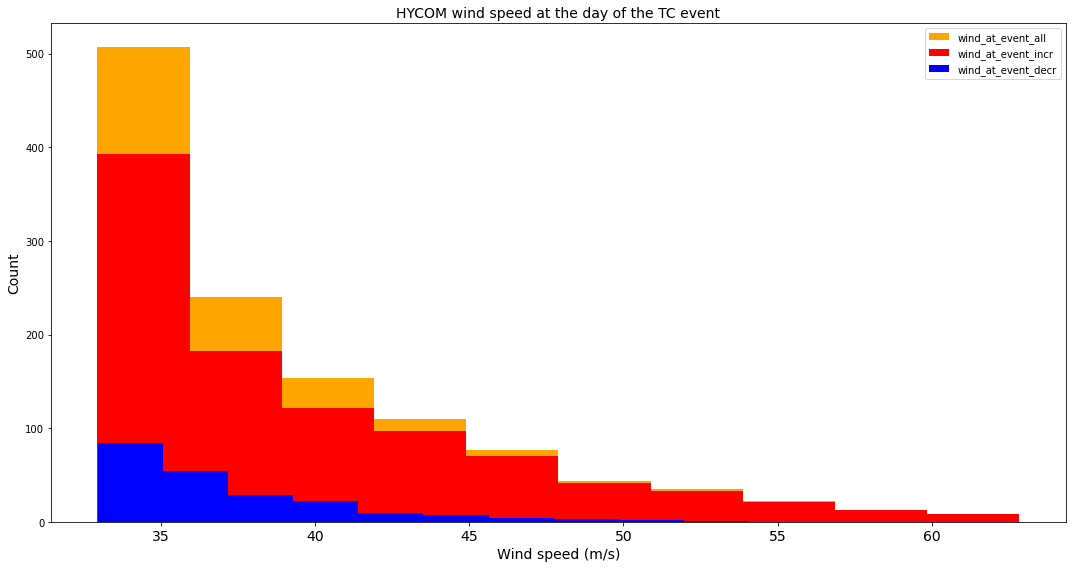

In [95]:
plt.figure(figsize=(15,8))
plt.hist(wind_at_event_all, color='orange', label='wind_at_event_all')
plt.hist(wind_at_event_incr, color='red', label='wind_at_event_incr')
plt.hist(wind_at_event_decr, color='blue', label='wind_at_event_decr')
plt.xlabel('Wind speed (m/s)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend()
plt.title('HYCOM wind speed at the day of the TC event', fontsize=14)
plt.tight_layout()
# plt.savefig('/Users/jacoposala/Desktop/CU/3.RESEARCH/ARGO_analysis/TC_HYCOM/check_masks_wind_vs_after_before_diff/HYCOM_hist_wind_speed_distance_from_tracks_at_sel_date.jpg')
    

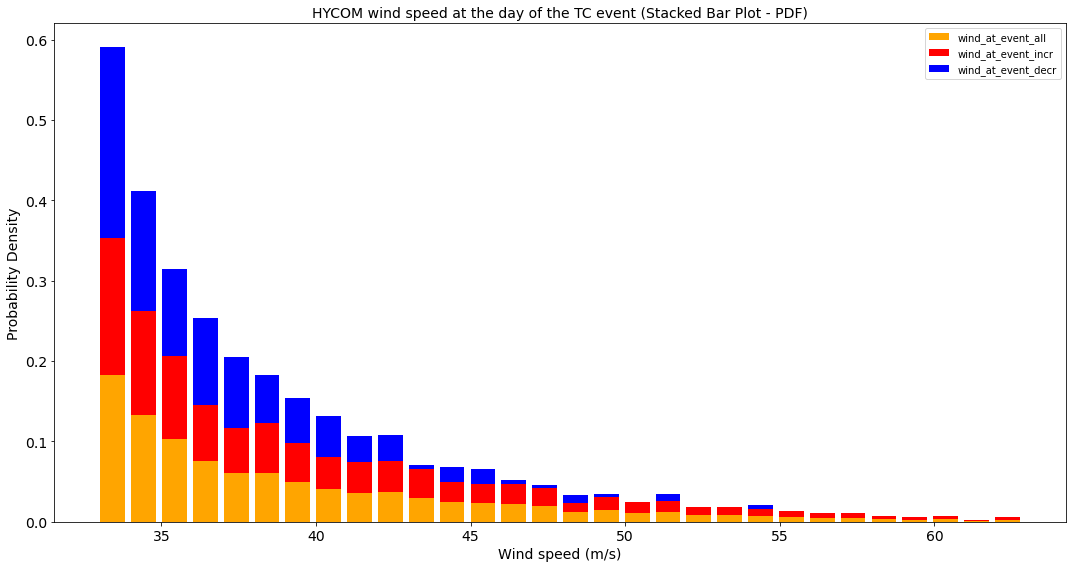

In [93]:
import numpy as np
import matplotlib.pyplot as plt

# Remove NaN values from the data
wind_at_event_all = wind_at_event_all[~np.isnan(wind_at_event_all)]
wind_at_event_incr = wind_at_event_incr[~np.isnan(wind_at_event_incr)]
wind_at_event_decr = wind_at_event_decr[~np.isnan(wind_at_event_decr)]

# Compute histograms and bin edges
hist_all, bin_edges = np.histogram(wind_at_event_all, bins=30, density=True)
hist_incr, _ = np.histogram(wind_at_event_incr, bins=bin_edges, density=True)
hist_decr, _ = np.histogram(wind_at_event_decr, bins=bin_edges, density=True)

# Compute bin centers
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

plt.figure(figsize=(15, 8))

# Create stacked bar plot
plt.bar(bin_centers, hist_all, color='orange', label='wind_at_event_all')
plt.bar(bin_centers, hist_incr, bottom=hist_all, color='red', label='wind_at_event_incr')
plt.bar(bin_centers, hist_decr, bottom=hist_all + hist_incr, color='blue', label='wind_at_event_decr')

plt.xlabel('Wind speed (m/s)', fontsize=14)
plt.ylabel('Probability Density', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.title('HYCOM wind speed at the day of the TC event (Stacked Bar Plot - PDF)', fontsize=14)
plt.tight_layout()
plt.savefig('/Users/jacoposala/Desktop/CU/3.RESEARCH/ARGO_analysis/TC_HYCOM/check_masks_wind_vs_after_before_diff/STACKED_HYCOM_hist_wind_speed_distance_from_tracks_at_sel_date.jpg')
plt.show()
